### Higher Dimensional Example

While the previous example demonstrated the basic usage of the rescomp package, 
one very important part still needs to be discussed: The hyperparameters of RC.

To do so, here we look at a much higher dimensional system than before, the
Lorenz-96 (L96) system, another chaotic system that, in constrast to the Lorenz-63 system, can be scaled to an arbitrarily large number of dimensions.  
Here we scale it to be 64 dimensional.

As always we import the needed packages, create an ESNWrapper object

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import rescomp

esn = rescomp.ESNWrapper()

and simulate the system. 

In [2]:
simulation_time_steps = 100000
lor_dim = 40
lor_dt = 0.05
lor_force = 5

starting_point = lor_force * np.ones(lor_dim) + 1e-5 * np.random.rand(lor_dim)
sim_data = rescomp.simulate_trajectory(
        sys_flag='lorenz_96', dt=lor_dt, time_steps=simulation_time_steps,
        starting_point=starting_point, force=lor_force)

As before, we want to train the system with data sampled from the chaotic
attractor we want to predict. As a result, we have to throw the first 10000
simulated data points away, as they are not on said attractor, but instead
correspond to transient system dynamics of the L96 system.

In [3]:
signal = sim_data[10000:]

An additional artifact of simulated systems like this, is that they are of course perfectly noiseless. For higher dimensional systems, this can result in RC "overfitting" the data, resulting in mostly accurate short term predictions at the cost of many diverging completely after some time.

Somewhat counterintuitively, adding a small amount of artificial noise to the training data can not only ensure the long term stability of the prediction, but also decrease the short term prediction error.

Note that this procedure depends on the system in question, and is of course not an issue when training with any real world data.

In [4]:
noise = np.random.normal(scale=0.01, size=signal.shape)
signal = signal + noise

Now we again want to create the reservoir/network, but this time the default
parameters are not sufficient for RC to learn the system dynamics. For the L96
system the following parameters work:

In [5]:
n_dim = 5000  # network dimension
n_rad = 0.5  # spectral radius
n_avg_deg = 3  # average network degree

The more complicated and higher dimensional the system is, the larger the 
network n_dim needs to be.  
The spectral radius n_rad should be smaller than 1 and must be larger than 0.  
The average network degree n_avg_deg can, in theory, be everything in 
(0, n_dim]. Typically sparse networks perform better than dense ones though.

These hyperparameters (and the ones below) have been found by trial and error 
for this system.  

So far no reliable heuristics exist for what the correct hyperparameter ranges
for an arbitrary system might be. See the FAQ for more details.

The numpy random seed, set to generate the same network everytime, is an
important hyperparameter too as different random networks can vary hugely in
their prediction performance even if all other hyperparameters are the same.

In [6]:
np.random.seed(0)

Finally, create the network with those parameters.

In [7]:
esn.create_network(n_dim=n_dim, n_rad=n_rad, n_avg_deg=n_avg_deg)

The train()/train_and_predict() methods too, have a set of hyperparameters one
needs to optimize. The most important of which are the regularization
parameter which is typically somewhere between 1e-4 and 1e-8

In [8]:
reg_param = 1e-6

and the scale of the random elements in the input matrix w_in which is usually
set to between 0.1 and 1.0

In [9]:
w_in_scale = 0.5

We also specify a nonlinear transformation to be used during the fitting of 
the output matrix, which vastly decreases number of failed, diverging 
predictions by breaking up harmful symmetries in the linear RC setup. For how 
and why see e.g.:  
[Herteux, J.; Räth, C. Breaking Symmetries of the Reservoir Equations in Echo State Networks. Chaos 2020, 30.](
https://aip.scitation.org/doi/10.1063/5.0028993)

In [10]:
w_out_fit_flag = "linear_and_square_r"

Define the number of training/prediction time steps

In [11]:
train_sync_steps = 1000
train_steps = 80000
pred_steps = 500

and train+predict the system using the above hyperparameters.

In [12]:
y_pred, y_test = esn.train_and_predict(
    signal, 
    train_sync_steps=train_sync_steps, 
    train_steps=train_steps,
    pred_steps=pred_steps, 
    reg_param=reg_param,
    w_in_scale=w_in_scale,
    w_out_fit_flag=w_out_fit_flag
)

Plot the results

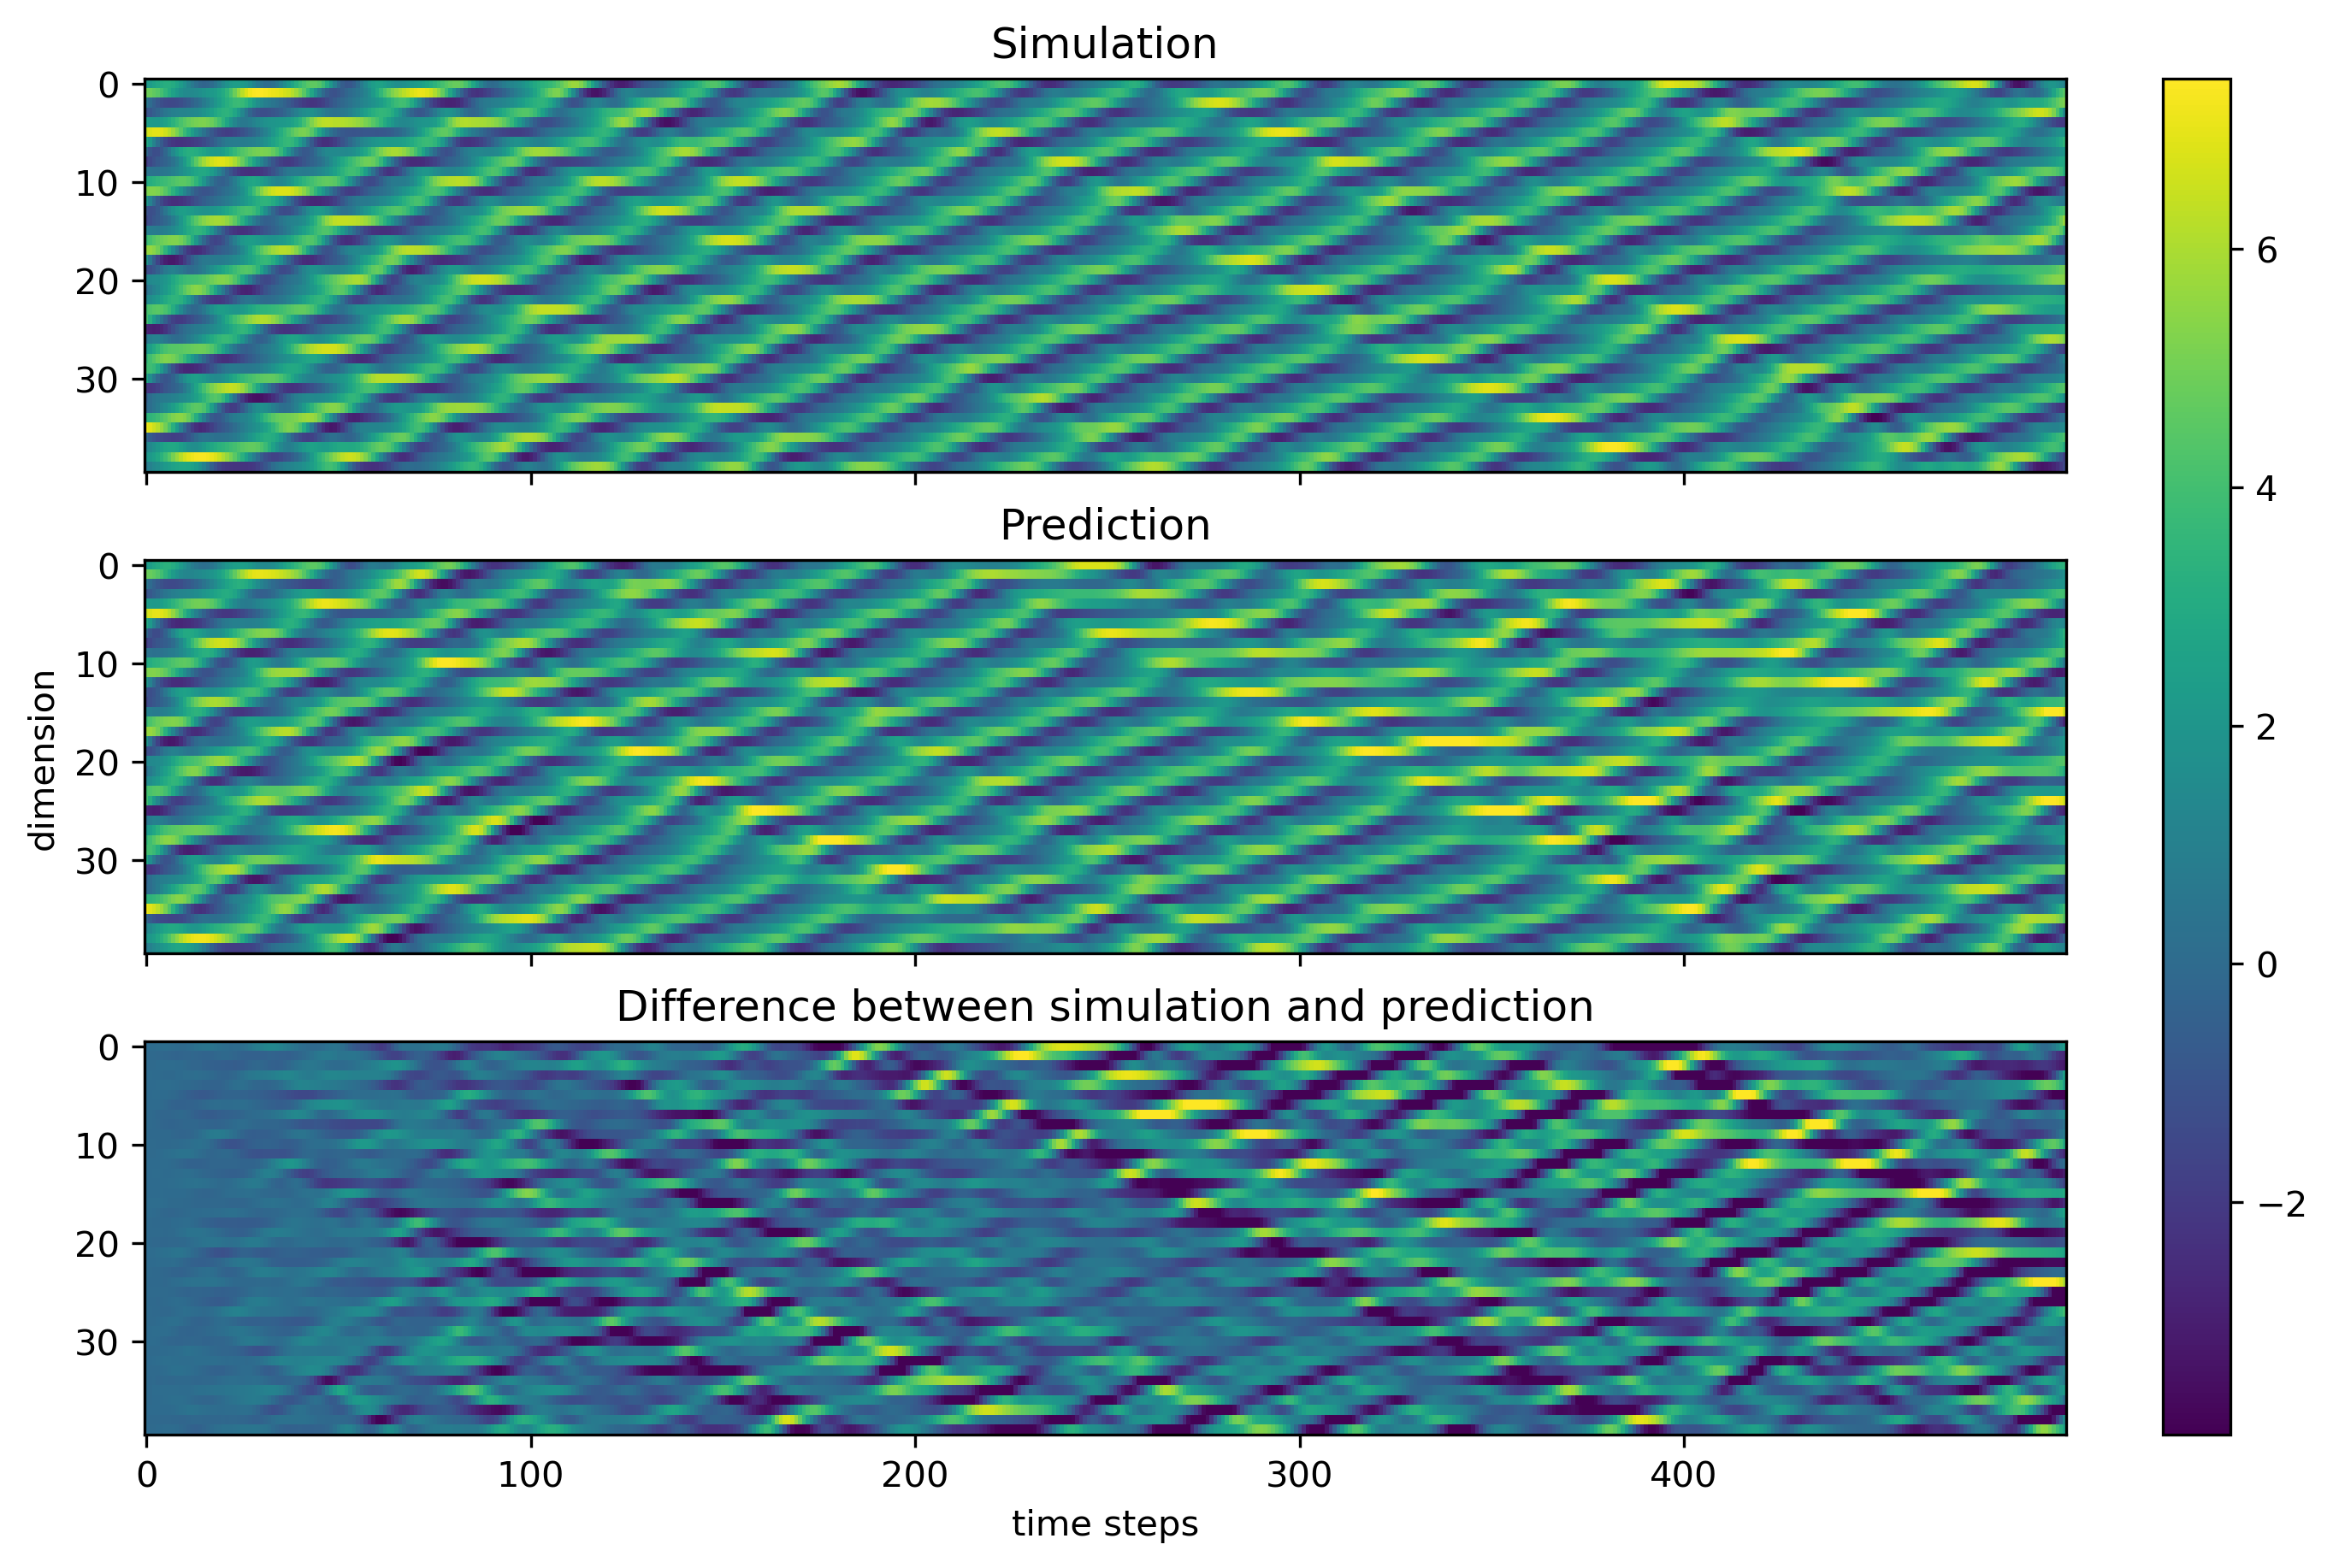

In [13]:
fig, axs = plt.subplots(3, 1, sharex="all", figsize=(9, 6),
                            constrained_layout=True, dpi=300)

vmin = np.min(y_test)
vmax = np.max(y_test)

im = axs[0].imshow(y_test.T, aspect='auto', vmin=vmin, vmax=vmax)
axs[0].set_title("Simulation")

axs[1].imshow(y_pred.T, aspect='auto', vmin=vmin, vmax=vmax)
axs[1].set_title("Prediction")

axs[2].imshow(y_pred.T - y_test.T, aspect='auto', vmin=vmin, vmax=vmax)
axs[2].set_title("Difference between simulation and prediction")

axs[1].set_ylabel("dimension")
axs[2].set_xlabel("time steps")
fig.colorbar(im, ax=axs)
plt.show()